In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install optuna

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.calibrate import calibrate_model
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side, soft_signal_labels_gaussian
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_stacked_residual_lstm
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.optuna_tuner import optimize_hyperparameters
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

# from scr.check_data import prepare_time_series
# from scr.calibrate import calibrate_model
# from scr.q_labels_matching import enrich_q_labels_trend_one_side
# from scr.visualisation import plot_enriched_actions_one_side
# from scr.dataset_builder import DatasetBuilderForYourColumns
# from scr.residual_lstm import build_stacked_residual_lstm
# from scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
# from scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
# from scr.optuna_tuner import optimize_hyperparameters
# from scr.indicators import *


In [2]:
# @title Параметры
# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps
SPLITS = (0.8, 0.15, 0.05)

SEQ_LEN = 7
BATCH_SIZE = 512
UNITS_PER_LAYER = [64, 32]
DROPOUT = 0.5
EPOCHS = 30
LR = 1e-4
GRAD_CLIP_NORM = 1.0
EARLY_STOPPING_PATIENCE = 20
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 5e-3
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 5
LR_RESTART_SHRINK = 0.5
BEST_PATH = "best_lstm.weights.h5"

FEE = 0.0002
SLIPPAGE = 0.0001
T = None

FEATURES = [
     'Open', 'High', 'Low', 'Close', 'Volume',
     'EMA_14', 'SMA_14', 'ADX_14', 'ATR_14', 'RSI_14', 'MACD_14', 'MACD_signal_14', 'MACD_hist_14',
     'STOCH_K_14', 'STOCH_D_14', 'BOLL_MID_14', 'BOLL_UP_14', 'BOLL_DN_14',
     'CCI_14', 'WILLR_14', 'MFI_14', 'ROC_14', 'VWAP_14',
     'EMA_21', 'SMA_21', 'ADX_21', 'ATR_21', 'RSI_21', 'MACD_21', 'MACD_signal_21', 'MACD_hist_21',
     'STOCH_K_21', 'STOCH_D_21', 'BOLL_MID_21', 'BOLL_UP_21', 'BOLL_DN_21',
     'CCI_21', 'WILLR_21', 'MFI_21', 'ROC_21', 'VWAP_21',
     'EMA_28', 'SMA_28', 'ADX_28', 'ATR_28', 'RSI_28', 'MACD_28', 'MACD_signal_28', 'MACD_hist_28',
     'STOCH_K_28', 'STOCH_D_28', 'BOLL_MID_28', 'BOLL_UP_28', 'BOLL_DN_28',
     'CCI_28', 'WILLR_28', 'MFI_28', 'ROC_28', 'VWAP_28',
     'EMA_35', 'SMA_35', 'ADX_35', 'ATR_35', 'RSI_35', 'MACD_35', 'MACD_signal_35', 'MACD_hist_35',
     'STOCH_K_35', 'STOCH_D_35', 'BOLL_MID_35', 'BOLL_UP_35', 'BOLL_DN_35',
     'CCI_35', 'WILLR_35', 'MFI_35', 'ROC_35', 'VWAP_35',
     'EMA_42', 'SMA_42', 'ADX_42', 'ATR_42', 'RSI_42', 'MACD_42', 'MACD_signal_42', 'MACD_hist_42',
     'STOCH_K_42', 'STOCH_D_42', 'BOLL_MID_42', 'BOLL_UP_42', 'BOLL_DN_42',
     'CCI_42', 'WILLR_42', 'MFI_42', 'ROC_42', 'VWAP_42',
     'EMA_49', 'SMA_49', 'ADX_49', 'ATR_49', 'RSI_49', 'MACD_49', 'MACD_signal_49', 'MACD_hist_49',
     'STOCH_K_49', 'STOCH_D_49', 'BOLL_MID_49', 'BOLL_UP_49', 'BOLL_DN_49',
     'CCI_49', 'WILLR_49', 'MFI_49', 'ROC_49', 'VWAP_49'
]
ACCOUNT_F = [
    "Unreal_PnL", "Flat_Steps", "Hold_Steps", "Drawdown", "Pos",
]


In [3]:
# Load and check data
raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")


From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [4]:
# Add indicators
# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(14, 50, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())


['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_14', 'SMA_14', 'ADX_14', 'ATR_14', 'RSI_14', 'MACD_14', 'MACD_signal_14', 'MACD_hist_14', 'STOCH_K_14', 'STOCH_D_14', 'BOLL_MID_14', 'BOLL_UP_14', 'BOLL_DN_14', 'OBV', 'CCI_14', 'WILLR_14', 'MFI_14', 'ROC_14', 'VWAP_14', 'EMA_21', 'SMA_21', 'ADX_21', 'ATR_21', 'RSI_21', 'MACD_21', 'MACD_signal_21', 'MACD_hist_21', 'STOCH_K_21', 'STOCH_D_21', 'BOLL_MID_21', 'BOLL_UP_21', 'BOLL_DN_21', 'CCI_21', 'WILLR_21', 'MFI_21', 'ROC_21', 'VWAP_21', 'EMA_28', 'SMA_28', 'ADX_28', 'ATR_28', 'RSI_28', 'MACD_28', 'MACD_signal_28', 'MACD_hist_28', 'STOCH_K_28', 'STOCH_D_28', 'BOLL_MID_28', 'BOLL_UP_28', 'BOLL_DN_28', 'CCI_28', 'WILLR_28', 'MFI_28', 'ROC_28', 'VWAP_28', 'EMA_35', 'SMA_35', 'ADX_35', 'ATR_35', 'RSI_35', 'MACD_35', 'MACD_signal_35', 'MACD_hist_35', 'STOCH_K_35', 'STOCH_D_35', 'BOLL_MID_35', 'BOLL_UP_35', 'BOLL_DN_35', 'CCI_35', 'WILLR_35', 'MFI_35', 'ROC_35', 'VWAP_35', 'EMA_42', 'SMA_42', 'ADX_42', 'ATR_42', 'RSI_42', 'MACD_42', 

In [5]:
# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_28'] > df['EMA_49']) & (df['Close'] > df['EMA_28']) & (df['ADX_14'] > 20)
sell_sig = (df['EMA_28'] < df['EMA_49']) & (df['Close'] < df['EMA_28']) & (df['ADX_14'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


In [6]:
# Q-labels
df = enrich_q_labels_trend_one_side(
    df,

    mode='tdlambda',
    H_max = 30,
    lam = 0.99,

    # mode='horizon',
    # H_max = 120,

    # mode='exit',

    fee=FEE,
    slippage=SLIPPAGE,
    use_mae_penalty=False,
    # mae_lambda=10
)

# Soft gaussian labels
# df = soft_signal_labels_gaussian(
#     df,
#     side_long = True,
#     blur_window=500,
#     blur_sigma=50,
#     mae_lambda=0,

# )
print(df[:500].to_string())


        timestamp     Open     High      Low    Close      Volume    EMA_14    SMA_14     ADX_14    ATR_14     RSI_14       MACD_14  MACD_signal_14  MACD_hist_14  STOCH_K_14  STOCH_D_14  BOLL_MID_14  BOLL_UP_14  BOLL_DN_14         OBV      CCI_14    WILLR_14     MFI_14    ROC_14   VWAP_14    EMA_21    SMA_21     ADX_21    ATR_21     RSI_21       MACD_21  MACD_signal_21  MACD_hist_21  STOCH_K_21  STOCH_D_21  BOLL_MID_21  BOLL_UP_21  BOLL_DN_21      CCI_21    WILLR_21     MFI_21    ROC_21   VWAP_21    EMA_28    SMA_28     ADX_28    ATR_28     RSI_28       MACD_28  MACD_signal_28  MACD_hist_28  STOCH_K_28  STOCH_D_28  BOLL_MID_28  BOLL_UP_28  BOLL_DN_28      CCI_28    WILLR_28     MFI_28    ROC_28   VWAP_28    EMA_35    SMA_35     ADX_35    ATR_35     RSI_35       MACD_35  MACD_signal_35  MACD_hist_35  STOCH_K_35  STOCH_D_35  BOLL_MID_35  BOLL_UP_35  BOLL_DN_35      CCI_35    WILLR_35     MFI_35    ROC_35   VWAP_35    EMA_42    SMA_42     ADX_42    ATR_42     RSI_42       MACD_42  MACD_si

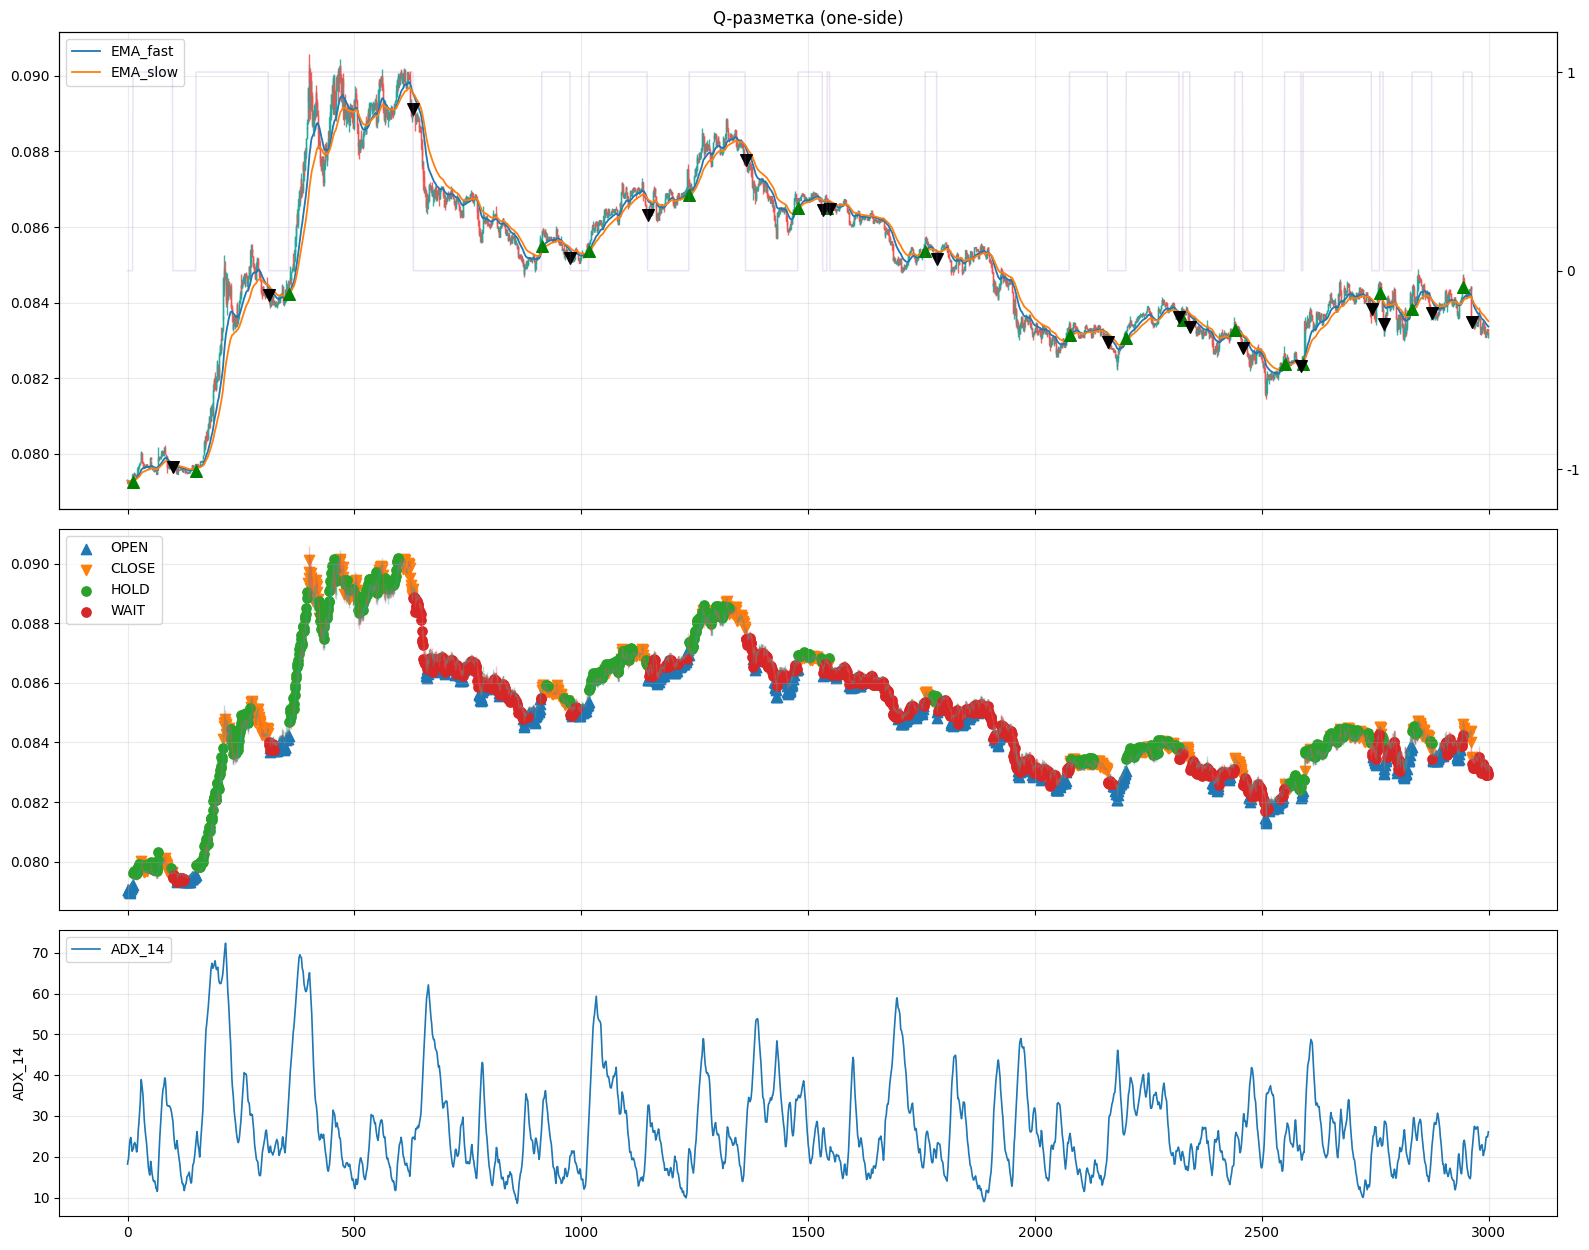

In [20]:
# Visualisation
plot_enriched_actions_one_side(
    df,
    start=1000,
    end=4000,
    indicators_price={
        'EMA_fast':df['EMA_28'],
        'EMA_slow':df['EMA_49'],
        },
    indicators_panels={
        'ADX_14':df['ADX_14'],
    }
)


In [7]:
# @title Нормализация и нарезка данных
enriched = df.copy()
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="q", # change to "q" if use q-labels
    tau=1, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    feature_cols = FEATURES,
    account_cols = ACCOUNT_F,
)
splits = builder.fit_transform(enriched, return_indices=True)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)
test_idx = splits["test"][-1]


In [8]:
xb, play_off = next(iter(train_ds.take(1)))
Y,_,_,_,_ = play_off
Y

<tf.Tensor: shape=(512, 4), dtype=float32, numpy=
array([[0.56787163, 0.        , 0.        , 0.43212837],
       [0.32504496, 0.        , 0.        , 0.674955  ],
       [0.5013872 , 0.        , 0.        , 0.4986128 ],
       ...,
       [0.        , 0.8968959 , 0.10310412, 0.        ],
       [0.7182713 , 0.        , 0.        , 0.28172868],
       [0.        , 0.17948505, 0.820515  , 0.        ]], dtype=float32)>

In [ ]:
# @title Оптимизация гиперпараметров

xb, _ = next(iter(train_ds.take(1)))
feature_dim = xb.shape[-1]
best_params = optimize_hyperparameters(
    train_ds,
    val_ds,
    seq_len=SEQ_LEN,
    feature_dim=feature_dim,
    n_trials=10,
    epochs=5,
)
UNITS_PER_LAYER = best_params['units_per_layer']
DROPOUT = best_params['dropout']
LR = best_params['lr']


Epoch 01 | train: loss 0.6933, acc 0.5242, ER -0.033478 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.056570, ICp 0.8275, ICs 0.8283
Epoch 02 | train: loss 0.6925, acc 0.5278, ER -0.033479 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.056146, ICp 0.8275, ICs 0.8283
Epoch 03 | train: loss 0.6924, acc 0.5284, ER -0.033443 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.056124, ICp 0.8275, ICs 0.8283
Epoch 04 | train: loss 0.6924, acc 0.5284, ER -0.033540 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.056298, ICp 0.8275, ICs 0.8283
Epoch 05 | train: loss 0.6924, acc 0.5280, ER -0.033447 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.056092, ICp 0.8275, ICs 0.8283
Epoch 06 | train: loss 0.6925, acc 0.5286, ER -0.033354 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.055943, ICp 0.8275, ICs 0.8283
Epoch 07 | train: loss 0.6924, acc 0.5282, ER -0.033476 | val: loss 0.6915, acc 0.5318, macroF1 0.3417, ER -0.056172, ICp 0.8275, ICs 0.8283
Epoch 08 | tr

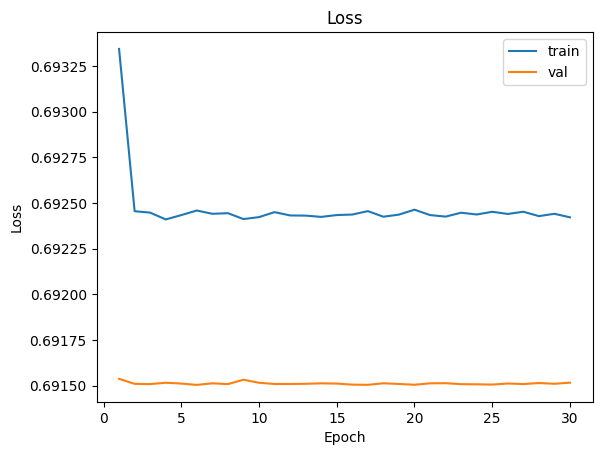

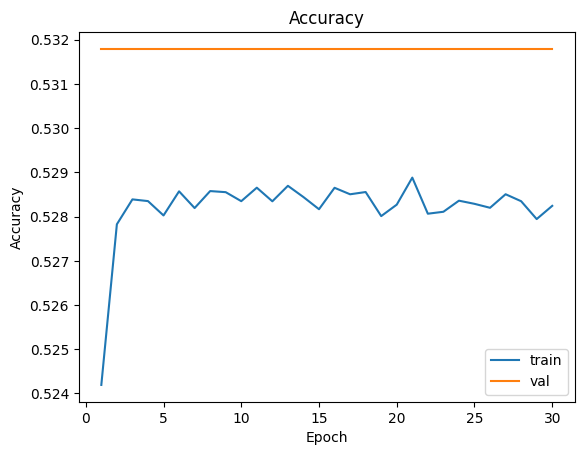

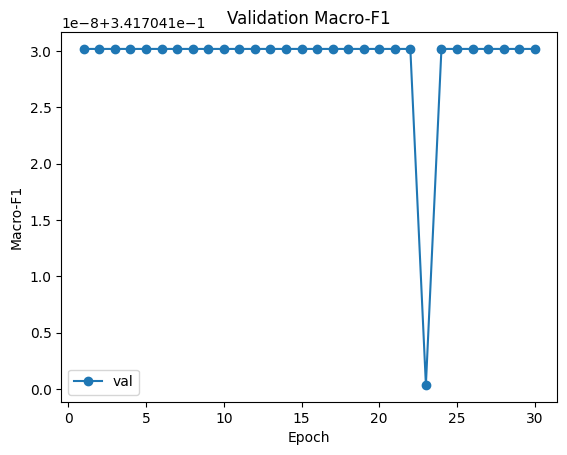

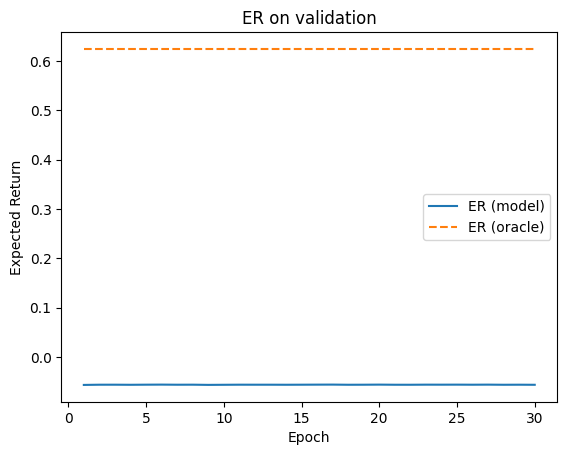

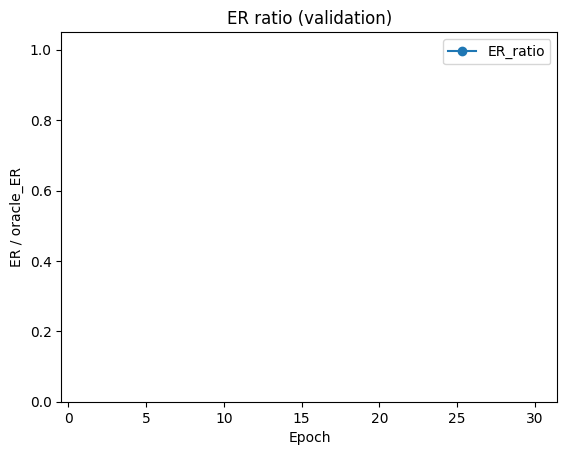

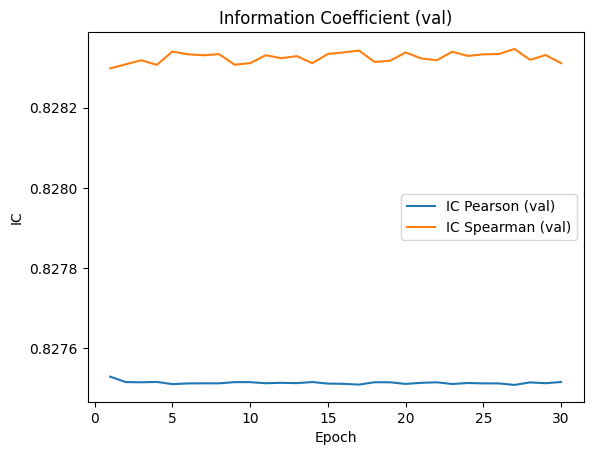

In [9]:
# @title Обучение модели
xb, _ = next(iter(train_ds.take(1)))
model = build_stacked_residual_lstm(seq_len=xb.shape[1],
                                    feature_dim=xb.shape[-1],
                                    units_per_layer=UNITS_PER_LAYER,
                                    dropout=DROPOUT)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_path=BEST_PATH,
)

plot_history_curves(history)


In [ ]:
# Loading weights
model = model.load_weights(BEST_PATH)

In [10]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")


TEST METRICS:
loss:0.6927992105484009
acc:0.5107648968696594
macro_f1:0.33245211839675903
f1_per_class:[0.0, 0.6684128046035767, 0.0, 0.6613956093788147]
exp_return:-0.01951608434319496
oracle_ER:0.7105084657669067
ER_ratio:-0.027467772364616394
IC_pearson:0.8293635249137878
IC_spearman:0.8478221297264099


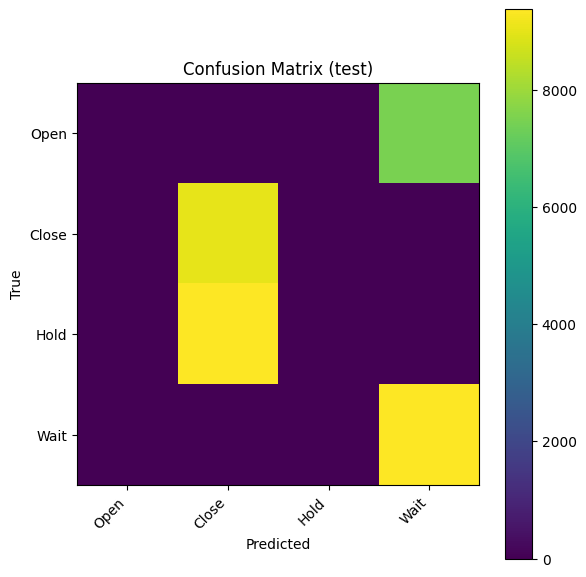

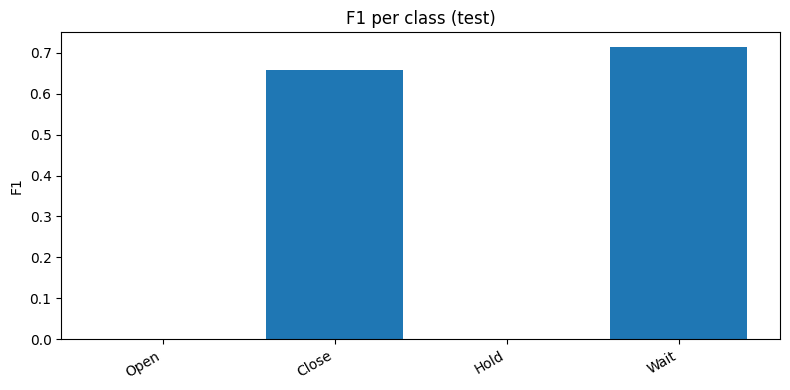

In [11]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)

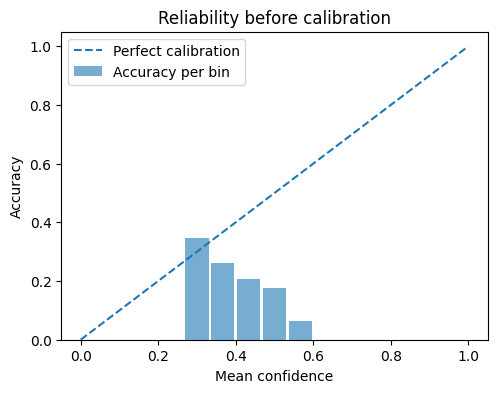

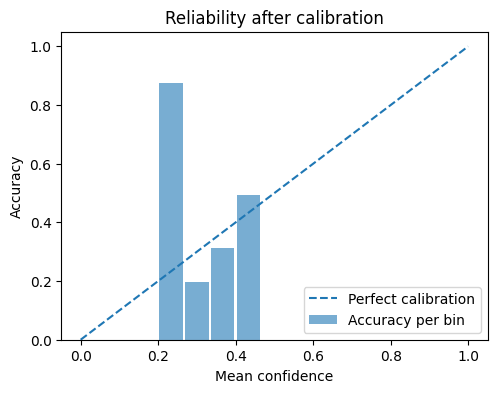

NLL before: 1.541984 | ECE before: 0.199433
NLL after:  1.341471 | ECE after:  0.082068
Temperature T: [  3.2318676  96.83287   300.03836     1.4461932]
Saved: artifacts/calibration/temperature.json
Температуры:  [3.231867551803589, 96.83287048339844, 300.0383605957031, 1.4461932182312012]


In [ ]:
# @title Калибровка модели
calib_info = calibrate_model(model, val_ds, per_class=True, init_T=1.0, plot=True)
T = calib_info['T']
print("Температуры: ", T)


In [ ]:
# @title Запуск бэктестов: референс стратегия, модель, учитель

def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['Signal_Rule'].iloc[:-1]:
        pos = env.position
        if sig == 1:
            action = 0 # OPEN
        elif sig == -1:
            action = 1 # CLOSE
        else:
            action = 2 if pos == 1 else 3 # HOLD or WAIT
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

def run_backtest_teacher(df, environment, t):
    env = environment
    env.reset()
    for a_row in df[['Q_Open', 'Q_Close', 'Q_Hold', 'Q_Wait']].iloc[:-1].to_numpy():
        mask = env.action_mask()
        a_row = a_row / max(t, 1e-6)
        a_row = np.where(mask > 0.0, a_row, 1e-9)
        a_row = a_row - np.max(a_row)
        a_row_exp = np.exp(a_row) * mask
        denom = a_row_exp.sum()
        Y = np.where(denom > 0.0, a_row_exp / np.maximum(denom, 1e-8), 1.0 / 4)
        action = np.argmax(Y)
        _, _, done, _ = env.step(action)

        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

start, end = int(test_idx[15000]), int(test_idx[-1])
df_bt = enriched.iloc[start:end+2].copy()

# env_ref = BacktestEnv(df_bt, cfg=LONG_CONFIG, price_col='Open')
# sim_ref = run_backtest(df_bt, env_ref)
# sim_ref.plot("reference")
# print('Метрики референс стратегии:')
# print(sim_ref.metrics_report())

env_tch = BacktestEnv(df_bt, cfg=LONG_CONFIG, price_col='Open')
sim_tch = run_backtest_teacher(df_bt, env_tch, 0.001)
sim_tch.plot("teacher")
print('Метрики учителя:')
print(sim_tch.metrics_report())

def model_infer(inputs, training=False):
    logits = model(inputs, training=False)
    return logits / T if T is not None else logits

env_model = run_backtest_with_logits(
    enriched,
    model_infer,
    feature_stats=builder.stats_features,
    seq_len=SEQ_LEN,
    start=start,
    feature_cols=builder.feature_names,
    price_col='Open',
    cfg=LONG_CONFIG,
)
env_model.plot("model")
print('\nМетрики модели:')
print(env_model.metrics_report())



# log_ref = sim_ref.logs()
log_model = env_model.logs()
log_teacher = sim_tch.logs()

plt.figure(figsize=(12,6))
# plt.plot(log_ref['equity'], label='reference')
plt.plot(log_model['equity'], label='model')
plt.plot(log_teacher['equity'], label='teacher')
plt.legend()
plt.title('Equity curves on test set')
plt.xlabel('step')
plt.ylabel('equity')
plt.show()
